# 요약



1.   데이터 준비 및 분석
  - git clone 데이터 준비
  - 시각화 및 분석
2.   베이스 모델
  - xgb 베이스 모델 제작
  - feature_importance_ 확인
3. 스케일링
  - MinMax
  - MaxAbs
  - Standard
4.   피처 튜닝
  - selector_best 5가지 선정하여 학습하여 결과 확인 후 피처 선정
5.   모델 선정
  - 대표 모델 gbm, xgb, lgbm 학습후 모델 선정
6.   하이퍼 파라미터 튜닝
  - Optuna를 사용하여 하이퍼 파라미터 튜닝
7.   풀데이터 활용
  - 선정된 피처, 모델, 파라미터를 사용해 풀데이터로 학습



# 데이터 준비 (수집, 준비, 분석)

In [ ]:
# 기본 라이브러리
import pandas as pd 
import numpy as np 

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 정제
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 학습 모델
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

# 모델 다운로드
from google.colab import files

# 스케일러
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# 피처 튜닝
from sklearn.feature_selection import f_regression, SelectKBest

# 검증용
from sklearn.metrics import mean_squared_error

# 데이터 path
data_path = '/content/project_2/res/'

- 데이터 수집 ( github 활용 )

In [ ]:
!git clone https://github.com/dkdlel395/project_2.git

Cloning into 'project_2'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 98 (delta 46), reused 69 (delta 29), pack-reused 0
Unpacking objects: 100% (98/98), 2.70 MiB | 6.49 MiB/s, done.


## 데이터 준비

In [ ]:
train      = pd.read_csv( data_path+'/train.csv')
test       = pd.read_csv( data_path+'/test.csv')
submission = pd.read_csv( data_path+'/sample_submission.csv')
train2 = pd.read_csv(data_path+'/ParisHousing.csv')

train = pd.concat([train,train2], axis=0).reset_index(drop=True)

train.shape, test.shape, submission.shape, train2.shape

((32730, 18), (15154, 17), (15154, 2), (10000, 17))

In [ ]:
train.shape, test.shape, submission.shape, train2.shape

((32730, 18), (15154, 17), (15154, 2), (10000, 17))

### 결측치, 고유값, 샘플값, 타입, 컬럼 확인

In [ ]:
def summary_feature_info( train ):
    sum_df = pd.DataFrame( train.dtypes, columns=['type'])   
    sum_df = sum_df.reset_index()
    sum_df.rename( columns={ 'index':'feature_name' }, inplace=True)
    sum_df['결측치수'] = train.isnull().sum().values
    sum_df['고유값수'] = train.nunique().values
    sum_df['sample_1'] = train.loc[0].values
    sum_df['sample_2'] = train.loc[1].values
    sum_df['sample_3'] = train.loc[2].values
    return sum_df

In [ ]:
summary_feature_info( train )

,feature_name,type,결측치수,고유값수,sample_1,sample_2,sample_3
0,id,float64,10000,22730,0.0,1.0,2.0
1,squareMeters,int64,0,9701,34291.0,95145.0,92661.0
2,numberOfRooms,int64,0,100,24.0,60.0,45.0
3,hasYard,int64,0,2,1.0,0.0,1.0
4,hasPool,int64,0,2,0.0,1.0,1.0
5,floors,int64,0,101,47.0,60.0,62.0
6,cityCode,int64,0,10174,35693.0,34773.0,45457.0
7,cityPartRange,int64,0,10,2.0,1.0,4.0
8,numPrevOwners,int64,0,10,1.0,4.0,8.0
9,made,int64,0,33,2000.0,2000.0,2020.0


In [ ]:
summary_feature_info( test )

,feature_name,type,결측치수,고유값수,sample_1,sample_2,sample_3
0,id,int64,0,15154,22730,22731,22732
1,squareMeters,int64,0,6433,47580,62083,90499
2,numberOfRooms,int64,0,100,89,38,75
3,hasYard,int64,0,2,0,0,1
4,hasPool,int64,0,2,1,0,1
5,floors,int64,0,100,8,87,37
6,cityCode,int64,0,6632,54830,8576,62454
7,cityPartRange,int64,0,10,5,10,9
8,numPrevOwners,int64,0,10,3,3,6
9,made,int64,0,32,1995,1994,1997


In [ ]:
summary_feature_info( train2 )

,feature_name,type,결측치수,고유값수,sample_1,sample_2,sample_3
0,squareMeters,int64,0,9483,75523.0,80771.0,55712.0
1,numberOfRooms,int64,0,100,3.0,39.0,58.0
2,hasYard,int64,0,2,0.0,1.0,0.0
3,hasPool,int64,0,2,1.0,1.0,1.0
4,floors,int64,0,100,63.0,98.0,19.0
5,cityCode,int64,0,9509,9373.0,39381.0,34457.0
6,cityPartRange,int64,0,10,3.0,8.0,6.0
7,numPrevOwners,int64,0,10,8.0,6.0,8.0
8,made,int64,0,32,2005.0,2015.0,2021.0
9,isNewBuilt,int64,0,2,0.0,1.0,0.0


## EDA를 통한 분석

### 데이터 분포도 확인

- price 값 분포

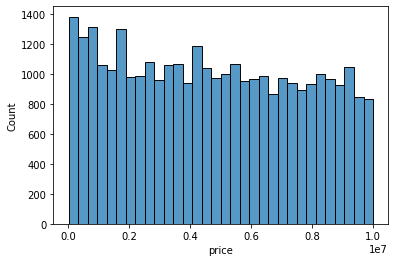

In [ ]:
sns.histplot( train['price'] ,line_kws={'color':'red'});

- 로그처리하면 정규분포에 멀어짐 로그처리 X

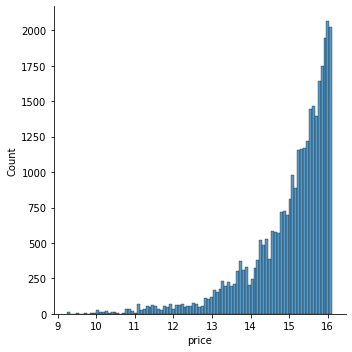

In [ ]:
sns.displot( np.log( train['price'] ) );

- 모든 컬럼 시각화
  - 순서형에 이상치가 여럿 보임

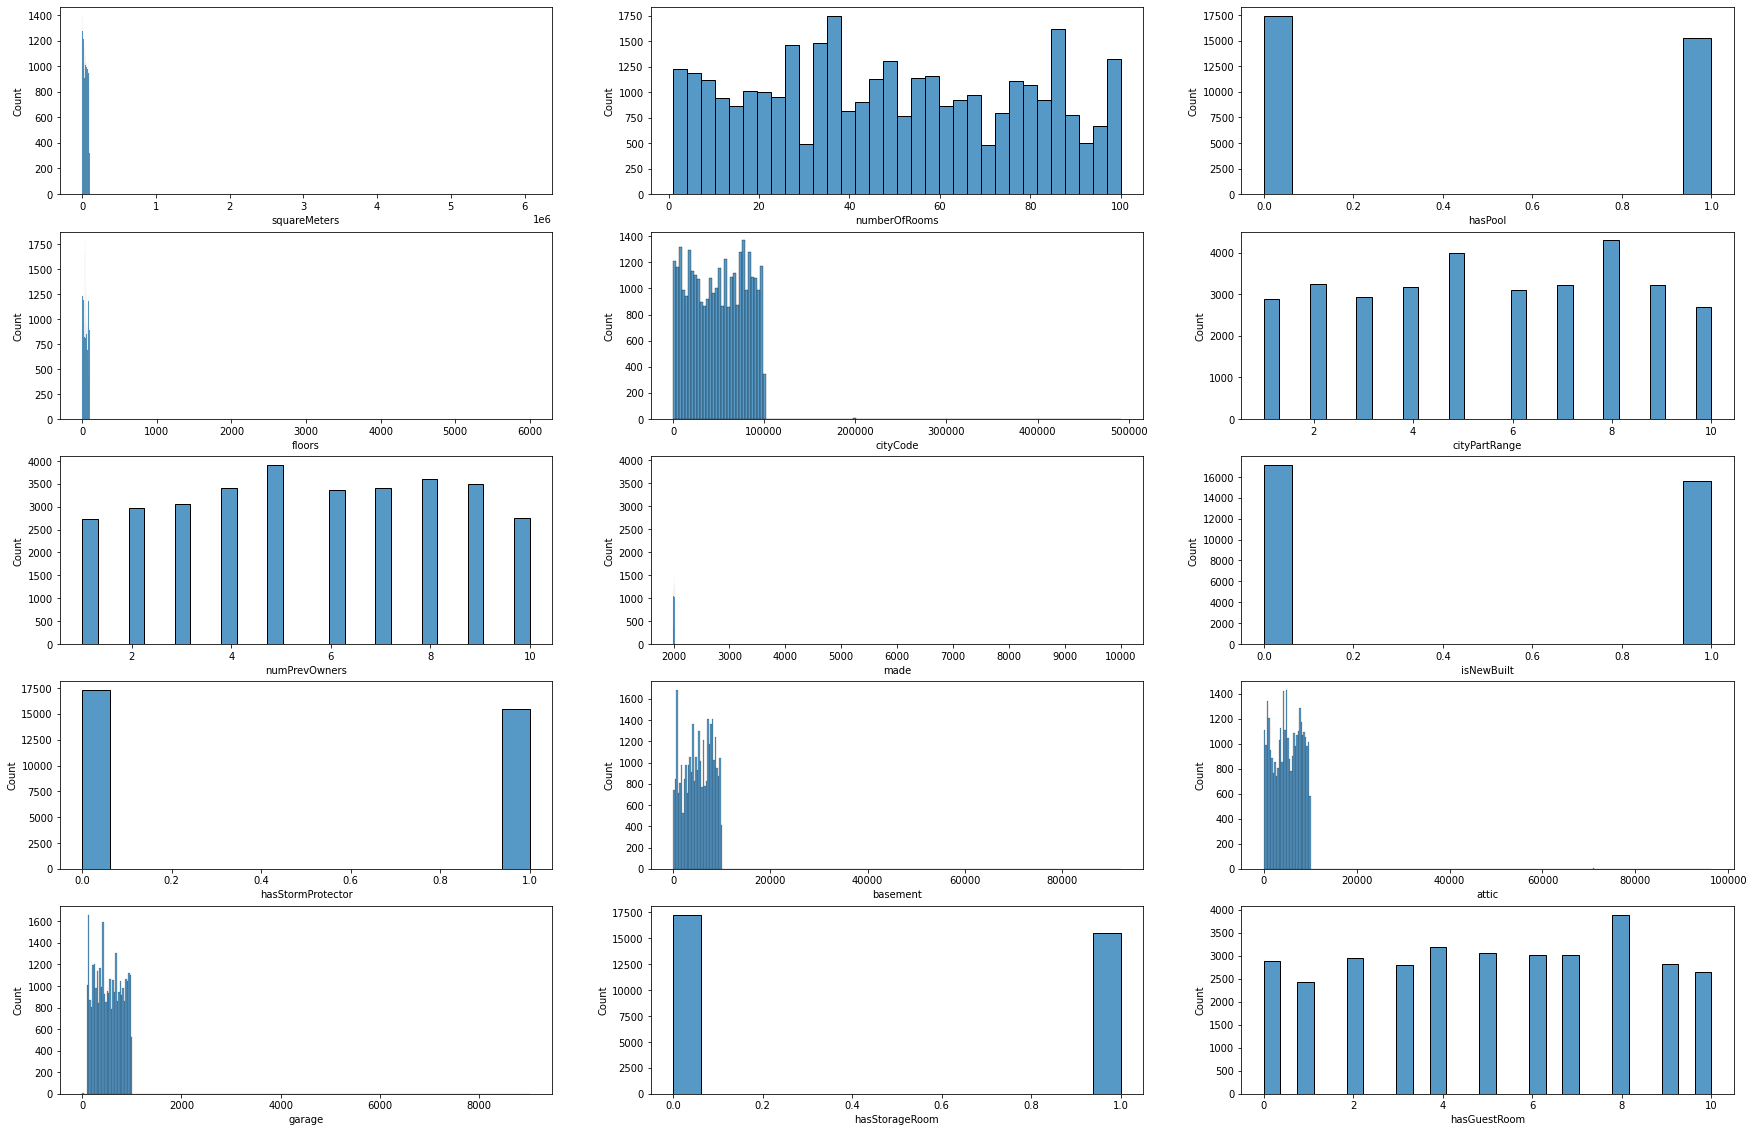

In [ ]:
fig, axes = plt.subplots( nrows=5, ncols=3, figsize=(30,20))

sns.histplot( train['squareMeters'] , ax=axes[0,0],   line_kws={'color':'red'});
sns.histplot( train['numberOfRooms'] , ax=axes[0,1], line_kws={'color':'red'});
sns.histplot( train['hasPool'] , ax=axes[0,2], line_kws={'color':'red'});
sns.histplot( train['floors'] , ax=axes[1,0], line_kws={'color':'red'});
sns.histplot( train['cityCode'] , ax=axes[1,1], line_kws={'color':'red'});
sns.histplot( train['cityPartRange'] , ax=axes[1,2], line_kws={'color':'red'});
sns.histplot( train['numPrevOwners'] , ax=axes[2,0], line_kws={'color':'red'});
sns.histplot( train['made'] , ax=axes[2,1], line_kws={'color':'red'});
sns.histplot( train['isNewBuilt'] , ax=axes[2,2], line_kws={'color':'red'});
sns.histplot( train['hasStormProtector'] , ax=axes[3,0], line_kws={'color':'red'});
sns.histplot( train['basement'] , ax=axes[3,1], line_kws={'color':'red'});
sns.histplot( train['attic'] , ax=axes[3,2], line_kws={'color':'red'});
sns.histplot( train['garage'] , ax=axes[4,0], line_kws={'color':'red'});
sns.histplot( train['hasStorageRoom'] , ax=axes[4,1], line_kws={'color':'red'});
sns.histplot( train['hasGuestRoom'] , ax=axes[4,2], line_kws={'color':'red'});

plt.show()

- 이상치 제거

In [ ]:
train_enc = pd.DataFrame()
train_enc['price'] = train['price']
train_enc['squareMeters'] = train['squareMeters'][train['squareMeters'].apply(lambda x:x < 6071329 )]
train_enc['floors'] = train['floors'][train['floors'].apply(lambda x:x < 1000 )]
train_enc['cityCode'] = train['cityCode'][train['cityCode'].apply(lambda x:x < 130000 )]
train_enc['basement'] = train['basement'][train['basement'].apply(lambda x:x < 20000 )]
train_enc['attic'] = train['attic'][train['attic'].apply(lambda x:x < 20000 )]
train_enc['garage'] = train['garage'][train['garage'].apply(lambda x:x < 1500 )]

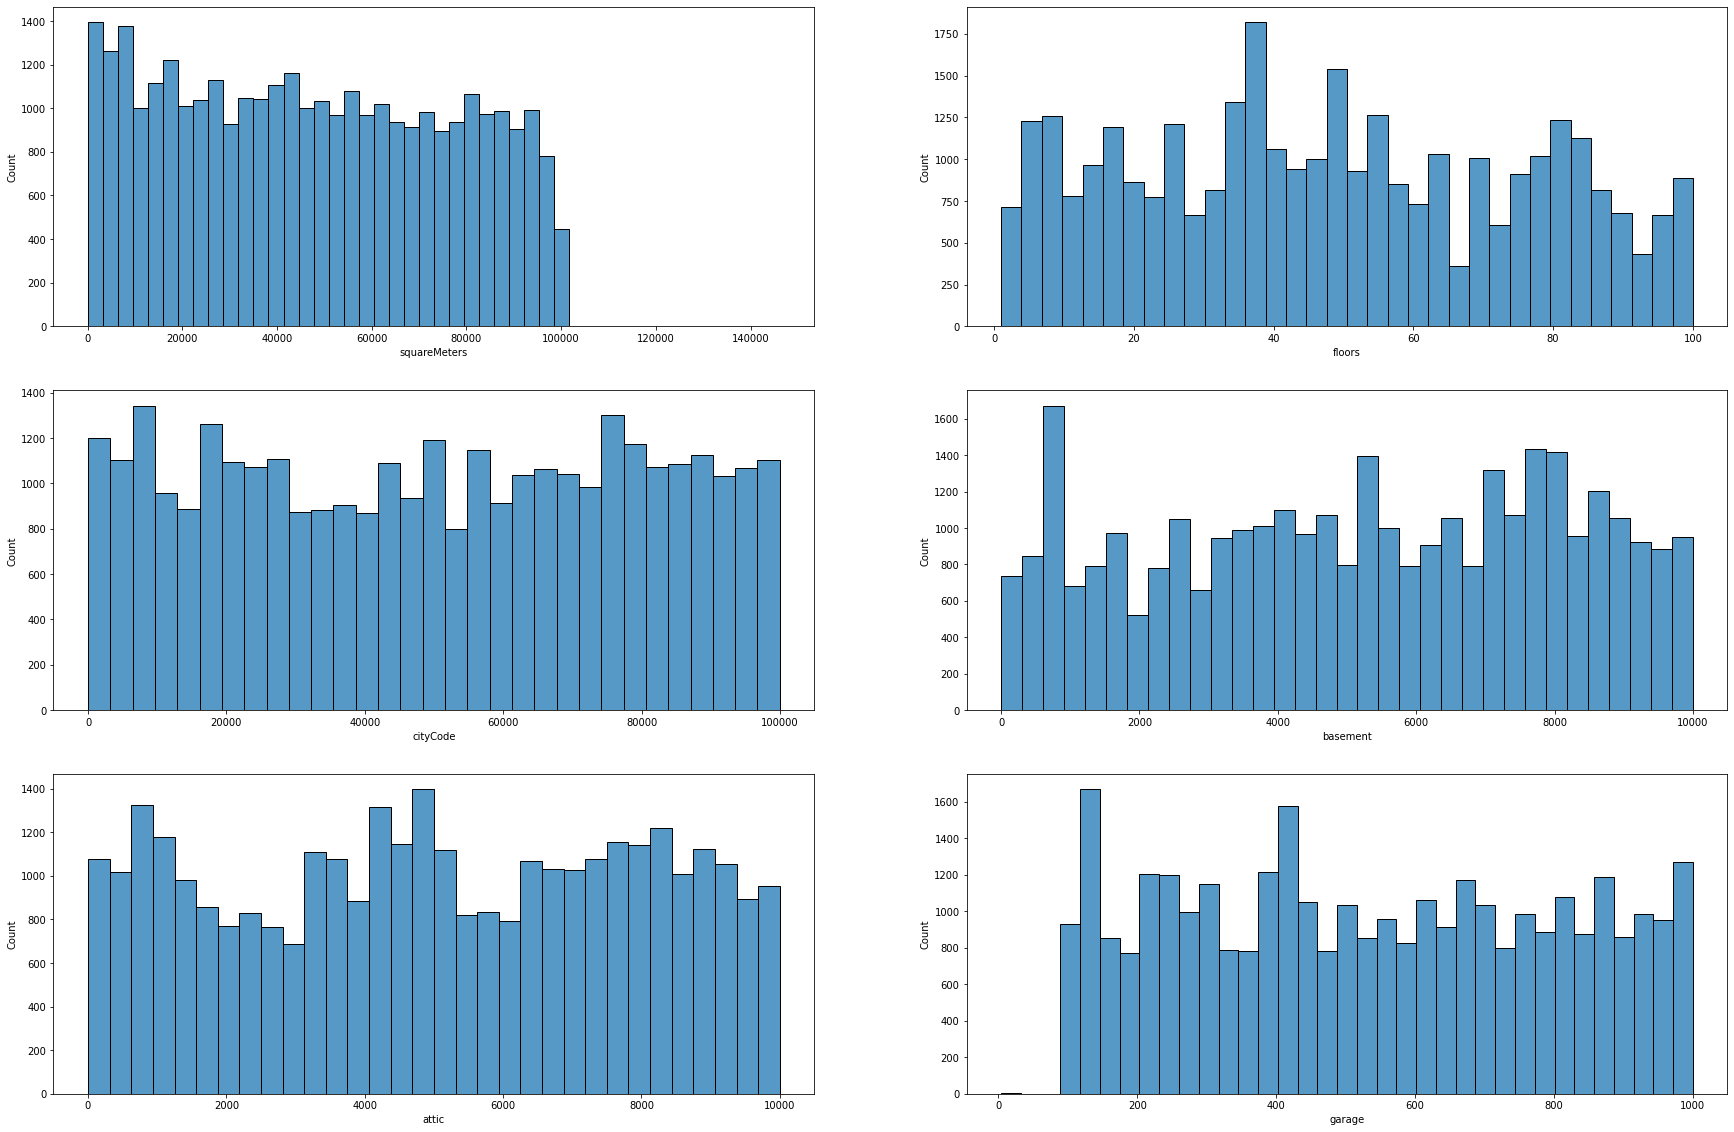

In [ ]:
fig, axes = plt.subplots( nrows=3, ncols=2, figsize=(30,20))

sns.histplot( train_enc['squareMeters'] , ax=axes[0,0],   line_kws={'color':'red'});
sns.histplot( train_enc['floors'] , ax=axes[0,1], line_kws={'color':'red'});
sns.histplot( train_enc['cityCode'] , ax=axes[1,0], line_kws={'color':'red'});
sns.histplot( train_enc['basement'] , ax=axes[1,1], line_kws={'color':'red'});
sns.histplot( train_enc['attic'] , ax=axes[2,0], line_kws={'color':'red'});
sns.histplot( train_enc['garage'] , ax=axes[2,1], line_kws={'color':'red'});

plt.show()

### bar차트 시각화
- 이진 데이터와 고유값 개수가 적은 컬럼 price 기준으로 bar차트 띄우기
- 이진데이터 : hasVard , hasPool, isNewBuilt, hasStormProtector , hasStorageRoom
- 의미 있는 데이터는 그나마 made

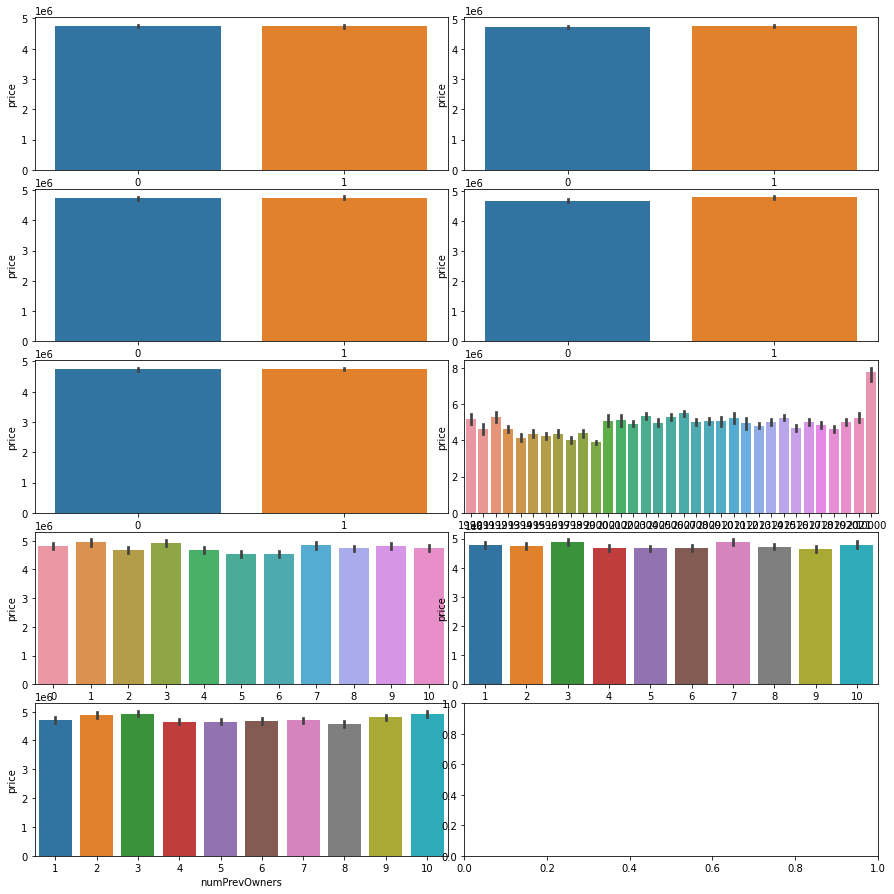

In [ ]:
fig, axes = plt.subplots( nrows=5, ncols=2 ,figsize=(30,20))
plt.tight_layout()
fig.set_size_inches(12,12)

# 바차트
sns.barplot(x='hasYard', y='price', data=train, ax=axes[0, 0])
sns.barplot(x='hasPool', y='price', data=train, ax=axes[0, 1])
sns.barplot(x='isNewBuilt', y='price', data=train, ax=axes[1, 0])
sns.barplot(x='hasStormProtector', y='price', data=train, ax=axes[1, 1])
sns.barplot(x='hasStorageRoom', y='price', data=train, ax=axes[2, 0])
sns.barplot(x='made', y='price', data=train, ax=axes[2, 1])
sns.barplot(x='hasGuestRoom', y='price', data=train, ax=axes[3, 0])
sns.barplot(x='cityPartRange', y='price', data=train, ax=axes[3, 1])
sns.barplot(x='numPrevOwners', y='price', data=train, ax=axes[4, 0])

'''
  - 해석
  - minute, second은 값이 오직 00 이고, 무의미하다 - 제거 확정
  - year : 2012도가 대여수가 더 많다. 오차범위도 문제 없음 - 사용
  - month : 비도 차이는 잘 보임 , 최고값들 6월이 피크이고, 10월까지 사용량이 높다, 1~3월에는 사용량이 적은게 확연하다 
           - season이 대분류 성격의 피처라서 일단 제거를 컨셉 
  - day : 20일 이후는 데이터는 학습불가해서 제거,  day간에도 큰 변별력이 없고, 오차범위가 다른 바를 침범할 정도 수준이여서 제거
  - hour : 시간대별로 대부분 사용량이 차이가 난다. 오차 범위도 문제없은 정도로 유지하고 있다 -> 사용
           - 출근시간대 (7~8시) 주변 시간대에 비해 피크값이 나온다
           - 퇴근시간대 (17~18시)에서 피크 사용량이 나온다
           - 사용
'''
plt.show()

### 적은 고유값 boxplot

- 여기서도 그나마 made

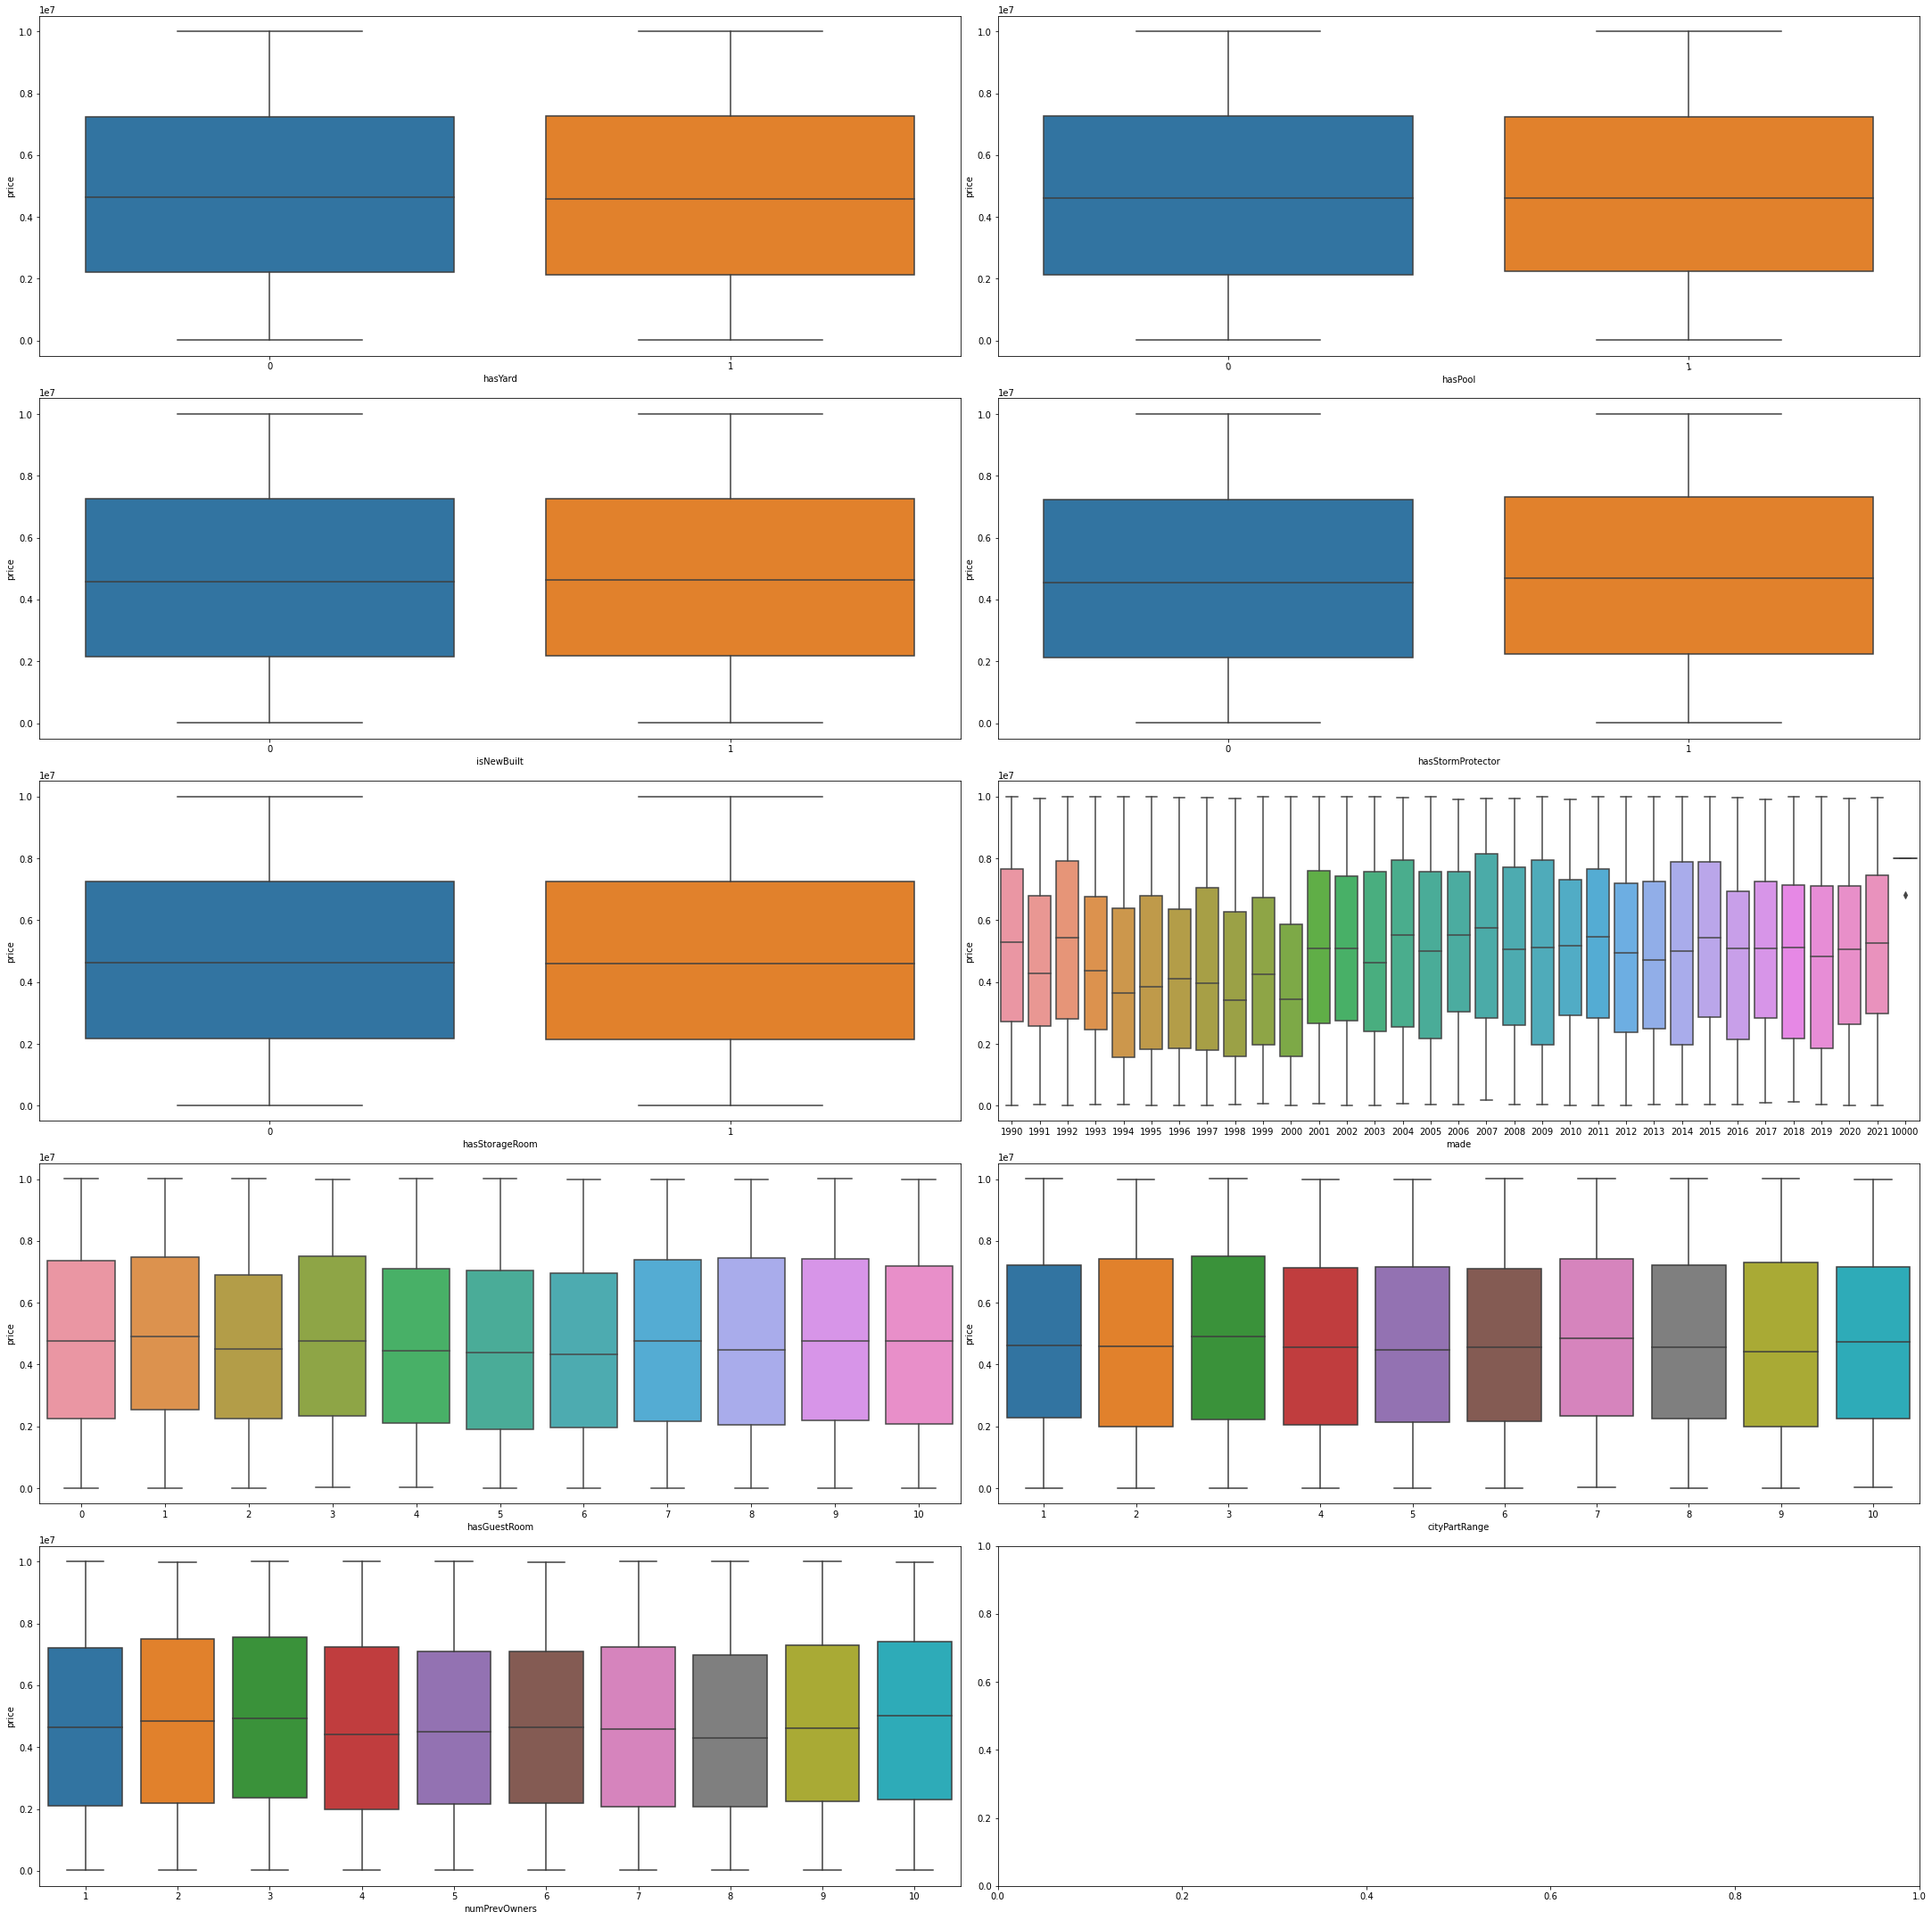

In [ ]:
'''
이진데이터 : hasYard , hasPool, isNewBuilt, hasStormProtector , hasStorageRoom
'''

# 2줄에 2칸
fig, axes = plt.subplots( nrows=5, ncols=2 ,figsize=(30,20))
plt.tight_layout()
fig.set_size_inches(30,30)

# 바차트
sns.boxplot(x='hasYard', y='price', data=train, ax=axes[0, 0])
sns.boxplot(x='hasPool', y='price', data=train, ax=axes[0, 1])
sns.boxplot(x='isNewBuilt', y='price', data=train, ax=axes[1, 0])
sns.boxplot(x='hasStormProtector', y='price', data=train, ax=axes[1, 1])
sns.boxplot(x='hasStorageRoom', y='price', data=train, ax=axes[2, 0])
sns.boxplot(x='made', y='price', data=train, ax=axes[2, 1])
sns.boxplot(x='hasGuestRoom', y='price', data=train, ax=axes[3, 0])
sns.boxplot(x='cityPartRange', y='price', data=train, ax=axes[3, 1])
sns.boxplot(x='numPrevOwners', y='price', data=train, ax=axes[4, 0])
# 회전
axes[0, 1].tick_params('x', labelrotation=10)

'''
  - 해석
  - season: 계절별 차이가 보임, 봄이 가장 낮다(1,2,3월 봄으로 봤기 때문), 보류
  - weather: 폭풍우(강한번개,천둥,눈폭풍) 치는날 거의 없다, 날씨가 나빠질수록 사용량이 줄어든다
    단 이상치들 때문에 전체 분포상으로 비슷해 보이지만(대분류단위로 묶다 보니 나오는 증상)
  - holiday: 중앙값은 비슷, 휴일아닐때 이상치가 많다 => 변별력이 잘 않보임 (제거할수도 있겟다) 
  - workingday: 중앙값은 비슷, 근무일일때 이상치가 많다 => 변별력이 잘 않보임 (제거할수도 있겟다)   
'''

plt.show()

### 포인트 플롯을 통한 시각화 (변별력)

- made가 가장 변별력이 있어보이기에 made 기준으로 고유값 개수가 적은 컬럼들을 price와 비교
- 결과 변별력없음 으로 판정

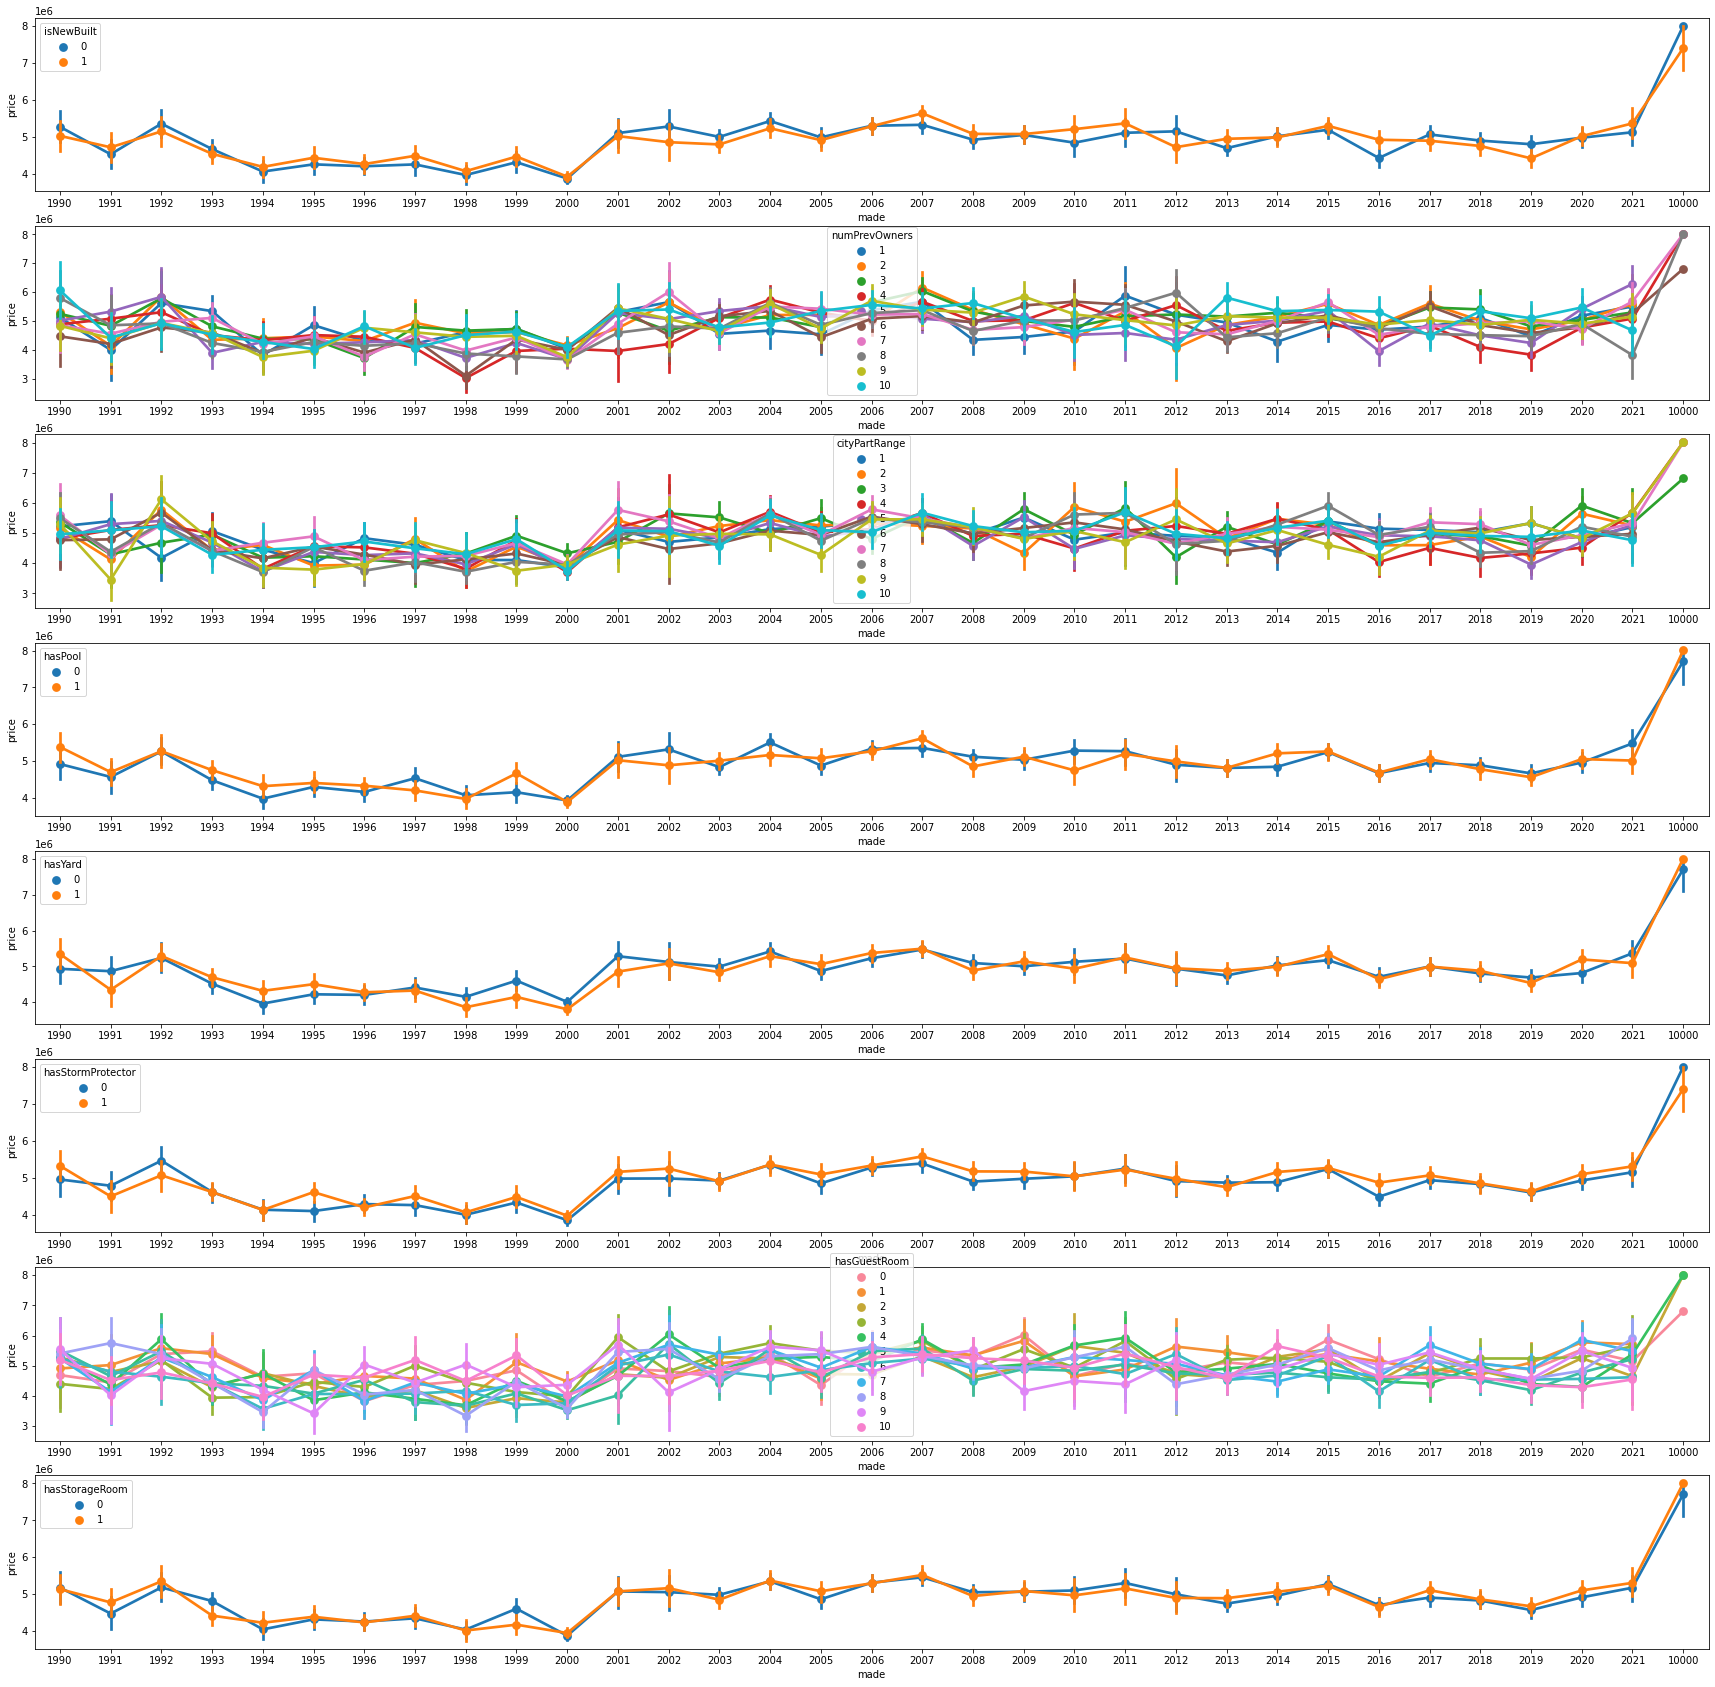

In [ ]:
fig, axes = plt.subplots( nrows=8 )
#plt.tight_layout()
fig.set_size_inches(30,30)

'''
  해석 
  - workingday : 일하는날(1) 출 퇴근시 대여 수량이 엄청 증가한다, 쉬는날(0) 12~15까지 대량이 더 높다
                 - 각 포인트의 신뢰구간(포인트별수직바)이 짧기 때문에 신뢰성이 높은(비교적 정확한) 데이터로 보인다\
  - holiday : 1값으로 분류된 포인트들이 신뢰구간이 0번 값 포인트에 많이 침범하고 있다(신뢰성 저하) 학습에 도움이 않될듯
  - weekday : 주 5일근무 기준 월 ~ 금요일은 워킹데이 1값와 유사, 토-일은 워킹데이 0과 유사
                - 대체적으로 사용하는데 무리는 없을듯 다만 (workingday와 상관관계가 있을수도 있을듯)
  - season : 계절 단위로 살펴보면, weekday(주 5일근무),workingday(1) 과 비슷한 추세를 보인다
               - fall, summer, winter 이계절은 거의 비슷하게 움직이고, 신뢰구간도 겹쳐져 잇어서 변별력이 조금 떨어진
  - weather : 가장 날씨가 않좋았을때 18시 부근만 데이터아 존재한다 => 이상치 제거  (값이 4는 제거)           
'''
sns.pointplot( x='made', y='price', data=train, hue='hasStorageRoom', ax=axes[7])
sns.pointplot( x='made', y='price', data=train, hue='hasGuestRoom', ax=axes[6])
sns.pointplot( x='made', y='price', data=train, hue='hasStormProtector', ax=axes[5])
sns.pointplot( x='made', y='price', data=train, hue='hasYard', ax=axes[4])
sns.pointplot( x='made', y='price', data=train, hue='hasPool', ax=axes[3])
sns.pointplot( x='made', y='price', data=train, hue='cityPartRange', ax=axes[2])
sns.pointplot( x='made', y='price', data=train, hue='numPrevOwners', ax=axes[1])
sns.pointplot( x='made', y='price', data=train, hue='isNewBuilt', ax=axes[0])

plt.show()

### 연속형 데이터 시각화

- 고유값수 > 100

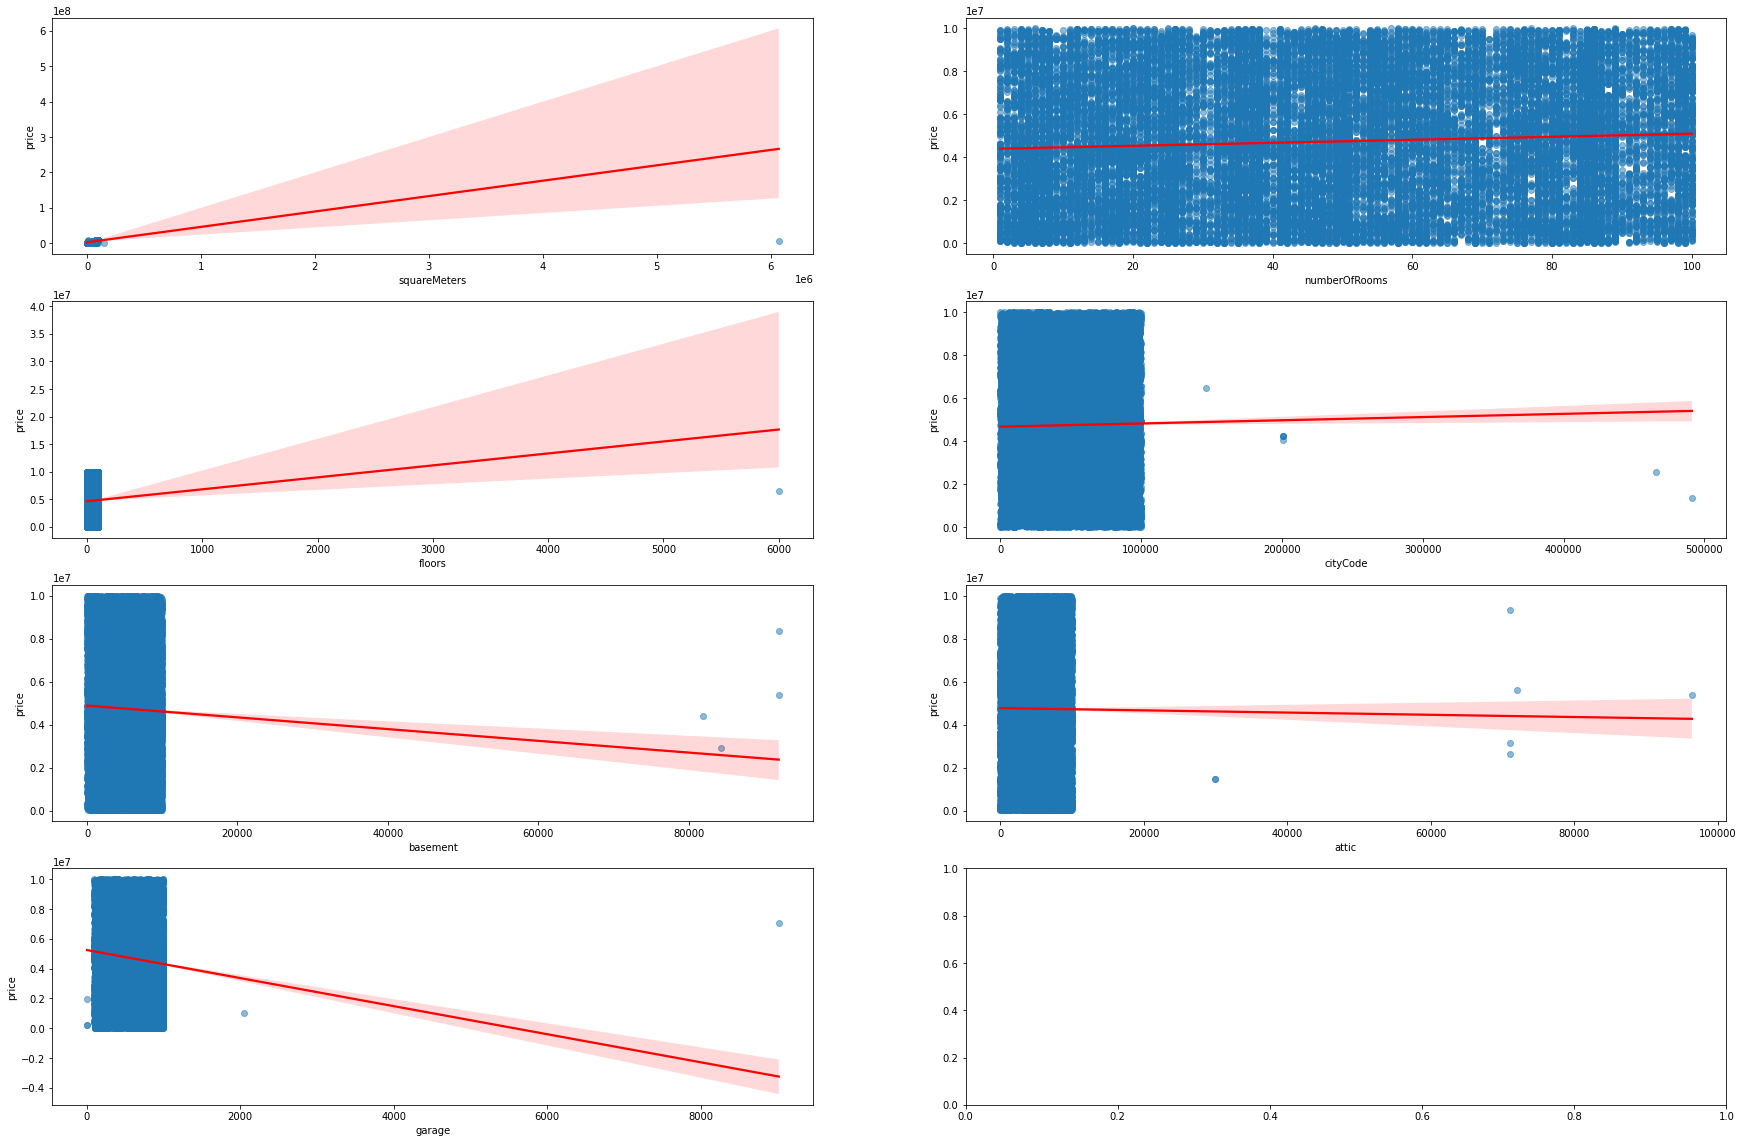

In [ ]:
fig, axes = plt.subplots( nrows=4, ncols=2 )
#plt.tight_layout()
fig.set_size_inches(30,20)

sns.regplot( x='squareMeters', y='price', data=train, ax=axes[0,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='numberOfRooms', y='price', data=train, ax=axes[0,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='floors', y='price', data=train, ax=axes[1,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='cityCode', y='price', data=train, ax=axes[1,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='basement', y='price', data=train, ax=axes[2,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='attic', y='price', data=train, ax=axes[2,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='garage', y='price', data=train, ax=axes[3,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )

plt.show()

- 이상치 제거

In [ ]:
# train_enc = pd.DataFrame()
# train_enc['price'] = train['price']
# train_enc['squareMeters'] = train['squareMeters'][train['squareMeters'].apply(lambda x:x < 6071329 )]
# train_enc['floors'] = train['floors'][train['floors'].apply(lambda x:x < 1000 )]
# train_enc['cityCode'] = train['cityCode'][train['cityCode'].apply(lambda x:x < 130000 )]
# train_enc['basement'] = train['basement'][train['basement'].apply(lambda x:x < 20000 )]
# train_enc['attic'] = train['attic'][train['attic'].apply(lambda x:x < 20000 )]
# train_enc['garage'] = train['garage'][train['garage'].apply(lambda x:x < 1500 )]

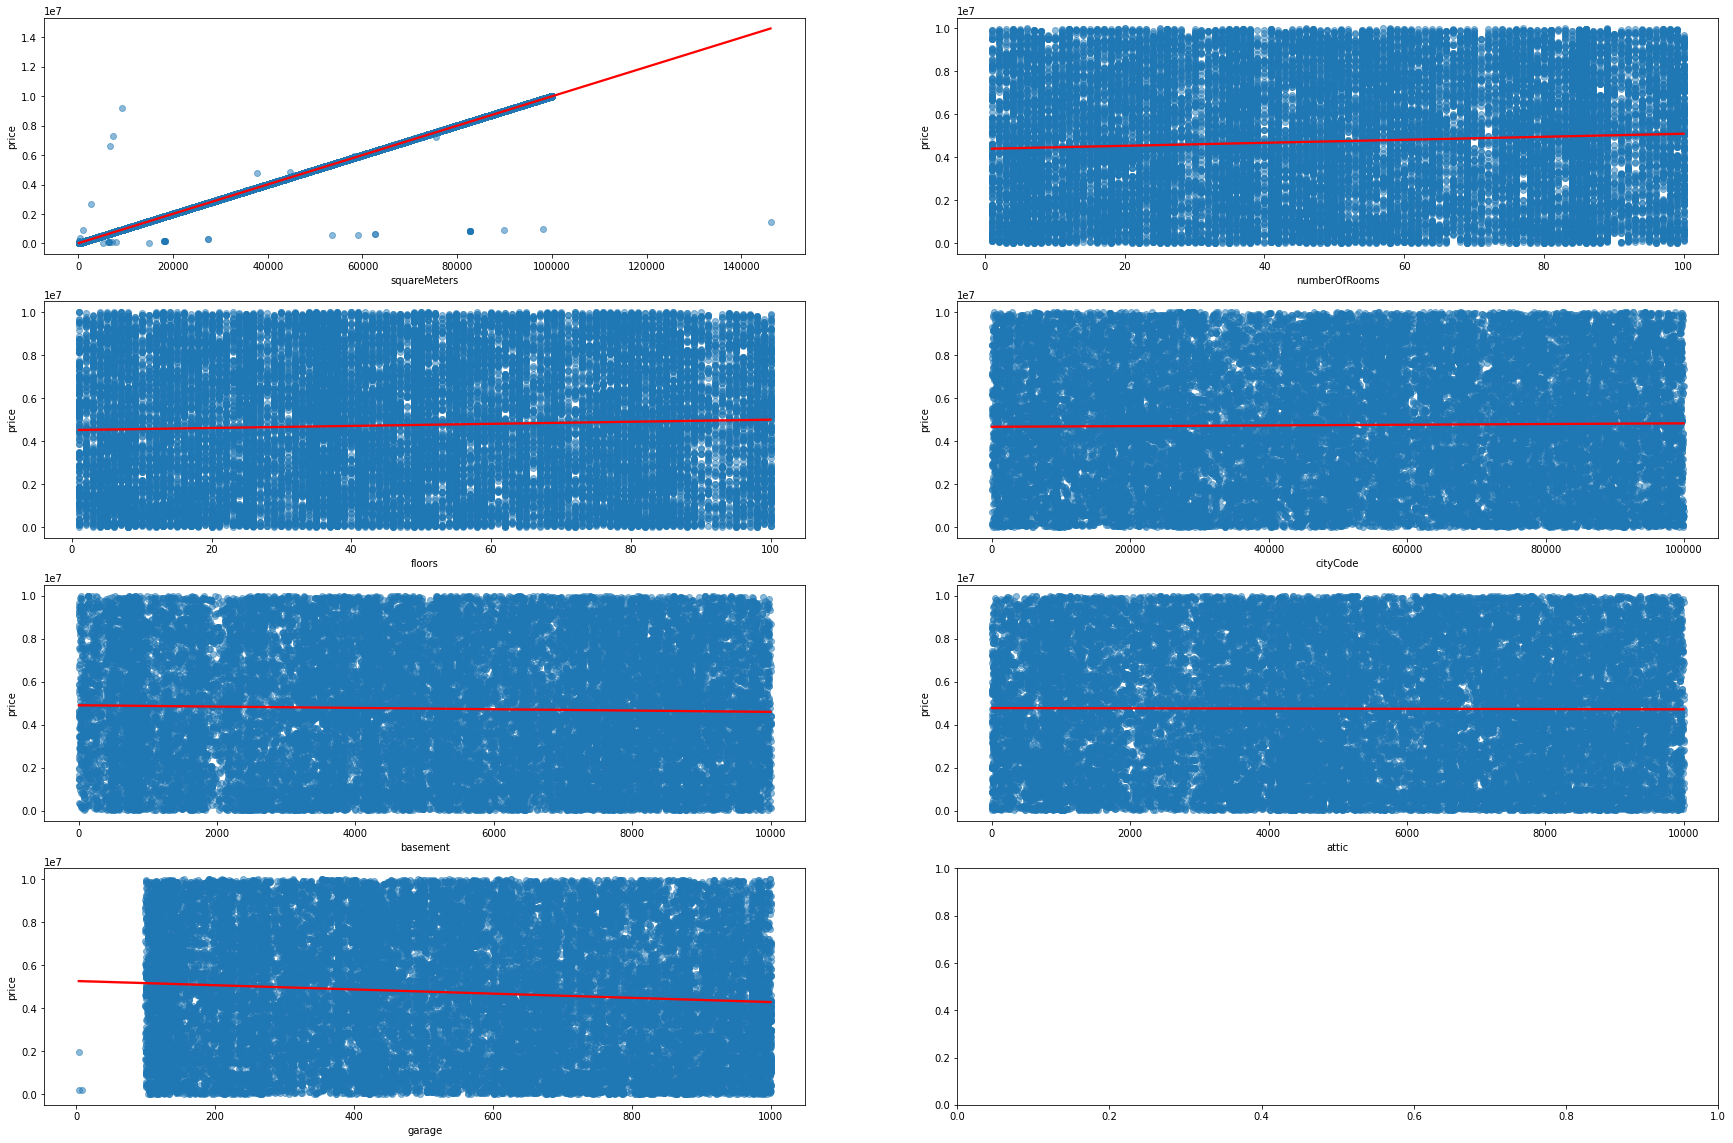

In [ ]:
fig, axes = plt.subplots( nrows=4, ncols=2 )
#plt.tight_layout()
fig.set_size_inches(30,20)

sns.regplot( x='squareMeters', y='price', data=train_enc, ax=axes[0,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='numberOfRooms', y='price', data=train, ax=axes[0,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='floors', y='price', data=train_enc, ax=axes[1,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='cityCode', y='price', data=train_enc, ax=axes[1,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='basement', y='price', data=train_enc, ax=axes[2,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='attic', y='price', data=train_enc, ax=axes[2,1], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )
sns.regplot( x='garage', y='price', data=train_enc, ax=axes[3,0], line_kws={'color':'red'}, scatter_kws={'alpha':0.5} )

plt.show()

### 수치형 데이터간 상관관계 체크

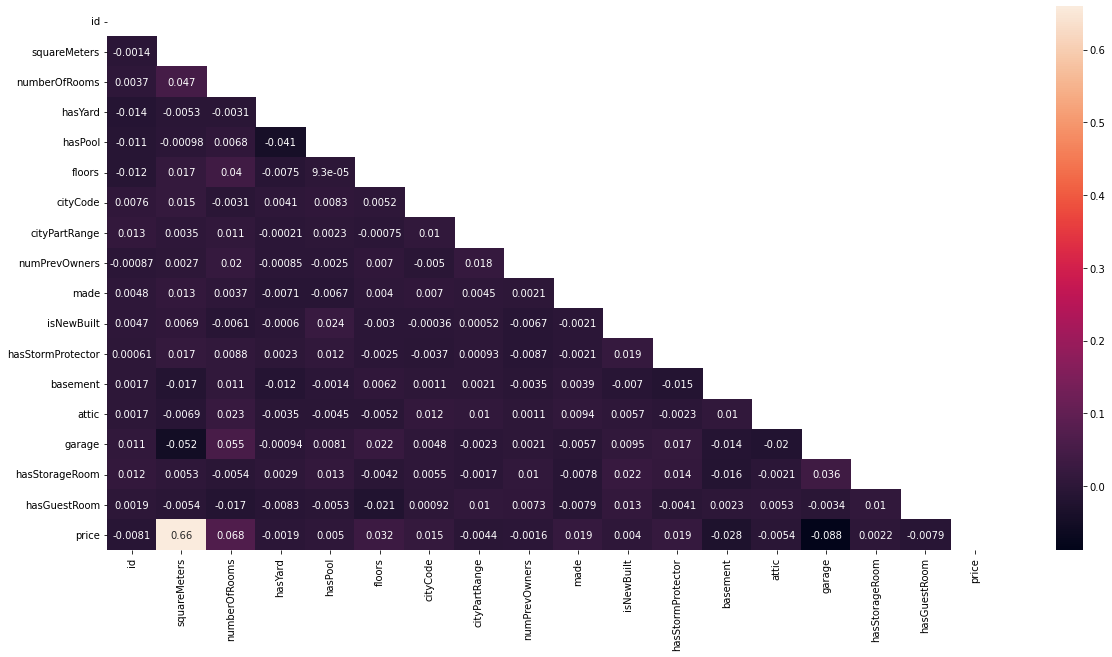

In [ ]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(),annot=True,mask=mask)

## EDA 결과

- 고유값 40개 미만 컬럼에서는 made가 변별력있는 데이터로 보였으나 pointplot 결과 관련성이 보이지 않았다.
- 고유값이 많은 컬럼에서는 squareMeters이 가장 관련있는 데이터로 보여졌으며 다른컬럼에서는 산포도에서 정답에 필요한 데이터로 보이지 않았음

# 베이스 모델
  - xgb 베이스 모델

- 데이터 로드

In [ ]:
train      = pd.read_csv( data_path+'/train.csv')
test       = pd.read_csv( data_path+'/test.csv')
submission = pd.read_csv( data_path+'/sample_submission.csv')
train2 = pd.read_csv(data_path+'/ParisHousing.csv')

train.shape, test.shape, submission.shape, train2.shape

((22730, 18), (15154, 17), (15154, 2), (10000, 17))

- 데이터 합치기

In [ ]:
train = pd.concat([train,train2], axis=0).reset_index(drop=True)

- 피처 제거

In [ ]:
train = train.drop('cityCode', axis=1)
train = train.drop('id', axis=1)
train = train.drop('cityPartRange', axis=1)
test = test.drop('cityCode', axis=1)
test = test.drop('id', axis=1)
test = test.drop('cityPartRange', axis=1)

- 이상치 제거

In [ ]:
train = train.query("made != 10_000") 
train = train.query("squareMeters < 1e6")
train = train.query("floors < 1000")
train = train.query("garage < 1500")

# train = train.query("basement < 20_000")
# train = train.query("attic < 20_000")

- 데이터 나누기

In [ ]:
X = train.drop(['price'],axis=1)
y = train['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
eval_set = [(X_test, y_test)]

- RMSE 검사 함수 생성

In [ ]:
def my_rmse(y_true, y_pred, transfer=True):
  if transfer:
    RMSE = mean_squared_error(y_true, y_pred)**0.5
  return RMSE

- XGBRegressor 모델 학습

In [ ]:
def xgb_train(X_train,X_test):
    model_params = {
    'objective': 'reg:squarederror',
    'boosting_type': 'gbtree',
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 3,
    'verbosity': 0,
    'early_stopping_rounds':100
    }
    xgb_model = XGBRegressor(**model_params)
    xgb_model.fit(X_train, y_train, eval_set=eval_set,verbose=0)

    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", rmse)
    return xgb_model

xgb_model = xgb_train(X_train,X_test)

baseline_test_pred = xgb_model.predict(test)
submission['price'] = baseline_test_pred
submission.to_csv('sub_xgb.csv', index=False)
submission.head()

Root Mean Squared Error:  161767.55139958998


,id,price
0,22730,4763804.0
1,22731,6207767.0
2,22732,9094824.0
3,22733,1630745.5
4,22734,6766762.0


<BarContainer object of 14 artists>

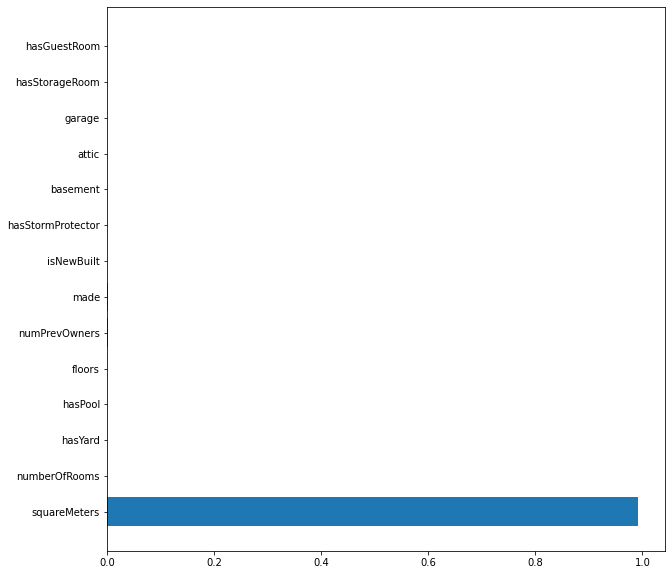

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(test.columns , xgb_model.feature_importances_)

- 모델 제출 ( 다운로드 )

In [ ]:
files.download('sub_xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 스케일러

- MinMax
- MaxAbs
- Standard

- 4가지 스케일링 101510.87695
- 4가지 스케일링 145311

In [ ]:


# # train_scale = MinMaxScaler().fit_transform(train_test)
# # train_scale = MaxAbsScaler().fit_transform(train_test)
# train_scale = StandardScaler().fit_transform(train_test)

# train_test = pd.DataFrame( columns = train_test.columns.values,data =train_scale)

# 피처 튜닝
  - SelectKBest 

### RMSE 검사 함수 생성

In [ ]:
# def my_rmse(y_true, y_pred, transfer=True):
#   if transfer:
#     RMSE = mean_squared_error(y_true, y_pred)**0.5
#   return RMSE

### selector

In [ ]:
selector = SelectKBest(f_regression, k=5)
X_kbest_train = selector.fit_transform(X_train, y_train)
X_kbest_test = selector.transform(X_test)
test_kb=selector.transform(test)

cols = X.columns
mask = selector.get_support()
selected_cols = cols[mask]

model_params = {
    'objective': 'reg:squarederror',
    'boosting_type': 'gbtree',
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 3,
    'verbosity': 0,
    'early_stopping_rounds':100
    }

kbest_model = XGBRegressor(**model_params)
kbest_model.fit(X_kbest_train, y_train, eval_set=[(X_kbest_test, y_test)], verbose=0)

XGBRegressor(boosting_type='gbtree', early_stopping_rounds=100,
             n_estimators=500, objective='reg:squarederror', verbosity=0)

In [ ]:
# 예측
my_rmse(y_test, kbest_model.predict(X_kbest_test))

158087.3976946189

In [ ]:
# 제출
xgb_kbest = kbest_model.predict(test_kb)
submission['price'] = xgb_kbest
submission.to_csv('xgb_kbest.csv', index=False)
files.download('xgb_kbest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<BarContainer object of 5 artists>

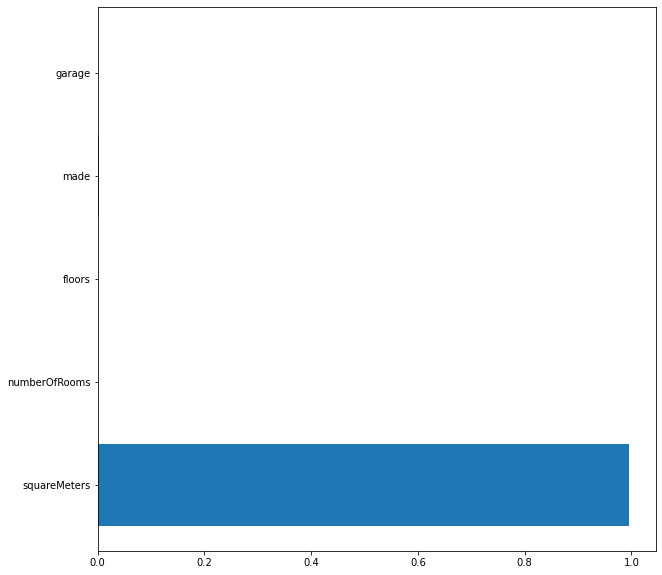

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(X[selected_cols].columns , kbest_model.feature_importances_)


# 모델 선정 
- 부스팅 ( xgboost, LGBM, GBM )

### GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbm_model = GradientBoostingRegressor(n_estimators=2000, random_state=0 ,verbose= 1,criterion='friedman_mse')
gbm_model.fit( X_train, y_train )

      Iter       Train Loss   Remaining Time 
         1 6922082155211.2383            3.08m
         2 5633764565731.9023            2.70m
         3 4585508291686.8408            2.51m
         4 3733880319780.9258            2.34m
         5 3040946956467.7666            2.24m
         6 2478177274521.7651            2.19m
         7 2020454898054.1836            2.18m
         8 1648679003072.9722            2.15m
         9 1345920852033.5027            2.11m
        10 1100471831054.4878            2.08m
        20 162139486135.7295            1.94m
        30 40072384191.9368            1.90m
        40 22423756704.8434            1.87m
        50 19568567617.8205            1.85m
        60 18419035218.2539            1.83m
        70 15769813972.4698            1.81m
        80 14056568580.0615            1.79m
        90 13210449358.1097            1.77m
       100 12230717699.6514            1.76m
       200  7502137865.7790            1.68m
       300  5509718370.9392      

GradientBoostingRegressor(n_estimators=2000, random_state=0, verbose=1)

In [ ]:
y_pred = gbm_model.predict( X_test )
my_rmse( y_test, y_pred )

158829.87469022837

In [ ]:
# 예측
my_rmse(y_test, gbm_model.predict( X_test ))

158829.87469022837

In [ ]:
# 제출
sub_y_pred = gbm_model.predict( test )
submission['price'] = sub_y_pred
submission.to_csv( 'sub_gbm.csv', index=False )
files.download('sub_gbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### XGBoost

In [ ]:
xgb_sci_wrapper = XGBRegressor(n_estimators=2000, random_state=0 ,objective='reg:squarederror')
eval_set = [ (X_test, y_test)]
xgb_sci_wrapper.fit( X_train, y_train, early_stopping_rounds=1000, eval_set=eval_set,
                     verbose =True, eval_metric='rmse')

[0]	validation_0-rmse:5.01745e+06
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:4.51923e+06
[2]	validation_0-rmse:4.07065e+06
[3]	validation_0-rmse:3.66739e+06
[4]	validation_0-rmse:3.30304e+06
[5]	validation_0-rmse:2.97554e+06
[6]	validation_0-rmse:2.68077e+06
[7]	validation_0-rmse:2.41514e+06
[8]	validation_0-rmse:2.17633e+06
[9]	validation_0-rmse:1.96105e+06
[10]	validation_0-rmse:1.76797e+06
[11]	validation_0-rmse:1.59369e+06
[12]	validation_0-rmse:1.43741e+06
[13]	validation_0-rmse:1.2966e+06
[14]	validation_0-rmse:1.1702e+06
[15]	validation_0-rmse:1.05629e+06
[16]	validation_0-rmse:954297
[17]	validation_0-rmse:862408
[18]	validation_0-rmse:780133
[19]	validation_0-rmse:706300
[20]	validation_0-rmse:640311
[21]	validation_0-rmse:581210
[22]	validation_0-rmse:528350
[23]	validation_0-rmse:481370
[24]	validation_0-rmse:439565
[25]	validation_0-rmse:402552
[26]	validation_0-rmse:369598
[27]	validation_0-rmse:340465
[28]	validation_0-rmse:31

XGBRegressor(n_estimators=2000, objective='reg:squarederror')

In [ ]:
# 예측
my_rmse(y_test, xgb_sci_wrapper.predict( X_test ))

151210.99040077973

In [ ]:
# 제출
sub_y_pred = xgb_sci_wrapper.predict( test )
submission['price'] = sub_y_pred
submission.to_csv( 'sub_xgb.csv', index=False )
files.download('sub_xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### LightGBM (LGBM)

In [ ]:
# 학습
eval_set = [ (X_test, y_test)]
L_model = LGBMRegressor(n_estimators=2000, random_state=0)
L_model.fit(X_train, y_train, early_stopping_rounds=10000, eval_set=eval_set, verbose=True, eval_metric='rmse')

[1]	valid_0's l2: 6.85522e+12	valid_0's rmse: 2.61825e+06
Training until validation scores don't improve for 10000 rounds.
[2]	valid_0's l2: 5.55961e+12	valid_0's rmse: 2.35788e+06
[3]	valid_0's l2: 4.50929e+12	valid_0's rmse: 2.12351e+06
[4]	valid_0's l2: 3.65858e+12	valid_0's rmse: 1.91274e+06
[5]	valid_0's l2: 2.96971e+12	valid_0's rmse: 1.72329e+06
[6]	valid_0's l2: 2.41101e+12	valid_0's rmse: 1.55274e+06
[7]	valid_0's l2: 1.95872e+12	valid_0's rmse: 1.39954e+06
[8]	valid_0's l2: 1.59208e+12	valid_0's rmse: 1.26177e+06
[9]	valid_0's l2: 1.29518e+12	valid_0's rmse: 1.13806e+06
[10]	valid_0's l2: 1.05459e+12	valid_0's rmse: 1.02693e+06
[11]	valid_0's l2: 8.59795e+11	valid_0's rmse: 927251
[12]	valid_0's l2: 7.02019e+11	valid_0's rmse: 837865
[13]	valid_0's l2: 5.73915e+11	valid_0's rmse: 757572
[14]	valid_0's l2: 4.70283e+11	valid_0's rmse: 685772
[15]	valid_0's l2: 3.86124e+11	valid_0's rmse: 621389
[16]	valid_0's l2: 3.18056e+11	valid_0's rmse: 563965
[17]	valid_0's l2: 2.6295e+11	

LGBMRegressor(n_estimators=2000, random_state=0)

In [ ]:
# 예측
my_rmse(y_test, L_model.predict( X_test ))

169071.11930748695

In [ ]:
# 제출
sub_y_pred = xgb_sci_wrapper.predict( test )
submission['price'] = sub_y_pred
submission.to_csv( 'sub_lgbm.csv', index=False )
files.download('sub_lgbm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 하이퍼 파라미터 튜닝
- optuna xgboost

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.9 MB/s eta 0:00:00


In [ ]:
# Optuna 실행
from optuna.samplers import TPESampler
import optuna

sampler = TPESampler(seed=10)

def objective(trial):


    param = {
        'objective': 'reg:squarederror',
        'boosting_type': 'gbtree',
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, step=0.01),
        "n_estimators": trial.suggest_int("n_estimators", 100,2000, step = 100),
        "max_depth": trial.suggest_int("max_depth", 1,10, step=1),
        'early_stopping_rounds':100,
        'verbose': -1
    }
    
    model = XGBRegressor(**param)
    xgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", rmse)
    return rmse
        
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=10) # 학습회수 설정

[I 2023-02-17 01:00:18,152] A new study created in memory with name: no-name-82961473-458d-4ad7-a6c8-da75e54ee788
[I 2023-02-17 01:00:22,742] Trial 0 finished with value: 152838.31958019023 and parameters: {'learning_rate': 0.78, 'n_estimators': 100, 'max_depth': 7}. Best is trial 0 with value: 152838.31958019023.


Root Mean Squared Error:  152838.31958019023


[I 2023-02-17 01:00:56,759] Trial 1 finished with value: 155088.04911797703 and parameters: {'learning_rate': 0.75, 'n_estimators': 1000, 'max_depth': 3}. Best is trial 0 with value: 152838.31958019023.


Root Mean Squared Error:  155088.04911797703


[I 2023-02-17 01:01:21,421] Trial 2 finished with value: 178887.62624322125 and parameters: {'learning_rate': 0.2, 'n_estimators': 1600, 'max_depth': 2}. Best is trial 0 with value: 152838.31958019023.


Root Mean Squared Error:  178887.62624322125


[I 2023-02-17 01:03:05,846] Trial 3 finished with value: 156697.96715317437 and parameters: {'learning_rate': 0.09, 'n_estimators': 1400, 'max_depth': 10}. Best is trial 0 with value: 152838.31958019023.


Root Mean Squared Error:  156697.96715317437


[I 2023-02-17 01:04:12,877] Trial 4 finished with value: 153406.0795452675 and parameters: {'learning_rate': 0.01, 'n_estimators': 1100, 'max_depth': 9}. Best is trial 0 with value: 152838.31958019023.


Root Mean Squared Error:  153406.0795452675


[I 2023-02-17 01:04:41,050] Trial 5 finished with value: 150420.57718020753 and parameters: {'learning_rate': 0.62, 'n_estimators': 1500, 'max_depth': 3}. Best is trial 5 with value: 150420.57718020753.


Root Mean Squared Error:  150420.57718020753


[I 2023-02-17 01:05:39,842] Trial 6 finished with value: 150223.2962238047 and parameters: {'learning_rate': 0.92, 'n_estimators': 1500, 'max_depth': 6}. Best is trial 6 with value: 150223.2962238047.


Root Mean Squared Error:  150223.2962238047


[I 2023-02-17 01:06:16,280] Trial 7 finished with value: 150210.05405439166 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 800, 'max_depth': 7}. Best is trial 7 with value: 150210.05405439166.


Root Mean Squared Error:  150210.05405439166


[I 2023-02-17 01:06:58,252] Trial 8 finished with value: 146496.09557067434 and parameters: {'learning_rate': 0.45, 'n_estimators': 900, 'max_depth': 7}. Best is trial 8 with value: 146496.09557067434.


Root Mean Squared Error:  146496.09557067434


[I 2023-02-17 01:08:02,977] Trial 9 finished with value: 149971.01737830564 and parameters: {'learning_rate': 0.52, 'n_estimators': 1400, 'max_depth': 7}. Best is trial 8 with value: 146496.09557067434.


Root Mean Squared Error:  149971.01737830564


In [ ]:
# 최적 파라미터
trial = study_xgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 146496.09557067434,
params {'learning_rate': 0.45, 'n_estimators': 900, 'max_depth': 7}


```

점수 146496

파라미터
learning_rate': 0.45,
'n_estimators': 900,
'max_depth': 7

```

In [ ]:
# 최적 파라미터 학습
param = study_xgb.best_trial.params
model = XGBRegressor(**param)
xgb_optuna_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
rmse = my_rmse(y_test, xgb_optuna_model.predict(X_test))

[01:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# 제출
optuna_xgb_test_pred = xgb_optuna_model.predict(test)
submission['price'] = optuna_xgb_test_pred
submission.to_csv('sub_xgb_optuna.csv', index=False)
files.download('sub_xgb_optuna.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- 모델 연구 결과 가져오기
  - 추후 optuna 학습시 추가시도로 넣을수 있음


In [ ]:
# Optuna 시도 결과 저장
xgb_optuna_trial = study_xgb.trials
xgb_optuna_trial = pd.DataFrame(xgb_optuna_trial)
xgb_optuna_trial.to_csv('xgb_optuna_trial.csv')
files.download('xgb_optuna_trial.csv')
xgb_optuna_trial.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,0
0,"FrozenTrial(number=0, state=TrialState.COMPLET..."
1,"FrozenTrial(number=1, state=TrialState.COMPLET..."
2,"FrozenTrial(number=2, state=TrialState.COMPLET..."
3,"FrozenTrial(number=3, state=TrialState.COMPLET..."
4,"FrozenTrial(number=4, state=TrialState.COMPLET..."


# 풀데이터 활용

In [ ]:
param = trial.params

In [ ]:
# 학습
model = XGBRegressor(**param)
xgb_final_model = model.fit( X, y, verbose=1)

[01:08:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# 제출
sub_y_pred = xgb_final_model.predict( test )
submission['price'] = sub_y_pred
submission.to_csv( 'sub_full_v1.csv', index=False )
files.download('sub_full_v1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>